In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  Naive, AutoARIMA, AutoCES, AutoTheta, AutoETS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datasetsforecast.losses import mae
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
warnings.filterwarnings("ignore")

In [4]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  10221.099609  115.116302  6.079517  10221.099609  156.500961   
2018-02-01  10397.900391  109.582008  5.985533  10397.900391  148.977051   
2018-03-01   6973.529785  108.956596  5.731613   6973.529785  146.682602   
2018-04-01   9240.549805  102.941681  5.566043   9240.549805  138.585083   
2018-05-01   7494.169922  100.349686  6.241441   7494.169922  135.095596   

Price                        High                               Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA      BTC-USD   
Date                                                                  
2018-01-01  6.14500  17712.400391  163.604202  6.23175  9402.290039   
2018-02-01  6.05000  11958.500000  156.912048  6.29925  6048.259766   
2018-03-01  5.78975  11704.099609  154.980881  6.36250  6683.930176   
2018-04-01  5.62250   9745.320312  154.875717  5.98125  6526.870117   
2018-05-01  6.30475   9964.500000  139.770554  6.51250  7090.680176   

Price                                   Open                       \
Ticker             IBM    NVDA       BTC-USD         IBM     NVDA   
Date                                                                
2018-01-01  146.787766  4.8625  14112.200195  147.705551  4.89450   
2018-02-01  138.049713  5.1000  10237.299805  156.013382  5.96300   
2018-03-01  142.007645  5.4250  10385.000000  148.690247  6.04775   
2018-04-01  137.772461  5.2575   7003.060059  146.596558  5.71850   
2018-05-01  133.747604  5.5550   9251.469727  138.288712  5.61425   

Price             Volume                          
Ticker           BTC-USD        IBM         NVDA  
Date                                              
2018-01-01  416247858176  151760375  11456216000  
2018-02-01  229717780480  107073687  14915528000  
2018-03-01  193751709184   98655478  14118440000  
2018-04-01  196550010624  128391583  11144008000  
2018-05-01  197611709696   92898293  11978240000

In [5]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() 
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,10221.099609,6.079517,115.116302
1,2018-02-01,10397.900391,5.985533,109.582008
2,2018-03-01,6973.529785,5.731613,108.956596
3,2018-04-01,9240.549805,5.566043,102.941681
4,2018-05-01,7494.169922,6.241441,100.349686


In [6]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,BTC-USD,2018-01-01,10221.099609
1,BTC-USD,2018-02-01,10397.900391
2,BTC-USD,2018-03-01,6973.529785
3,BTC-USD,2018-04-01,9240.549805
4,BTC-USD,2018-05-01,7494.169922
...,...,...,...
175,IBM,2022-08-01,117.183617
176,IBM,2022-09-01,109.754761
177,IBM,2022-10-01,127.750084
178,IBM,2022-11-01,137.551437


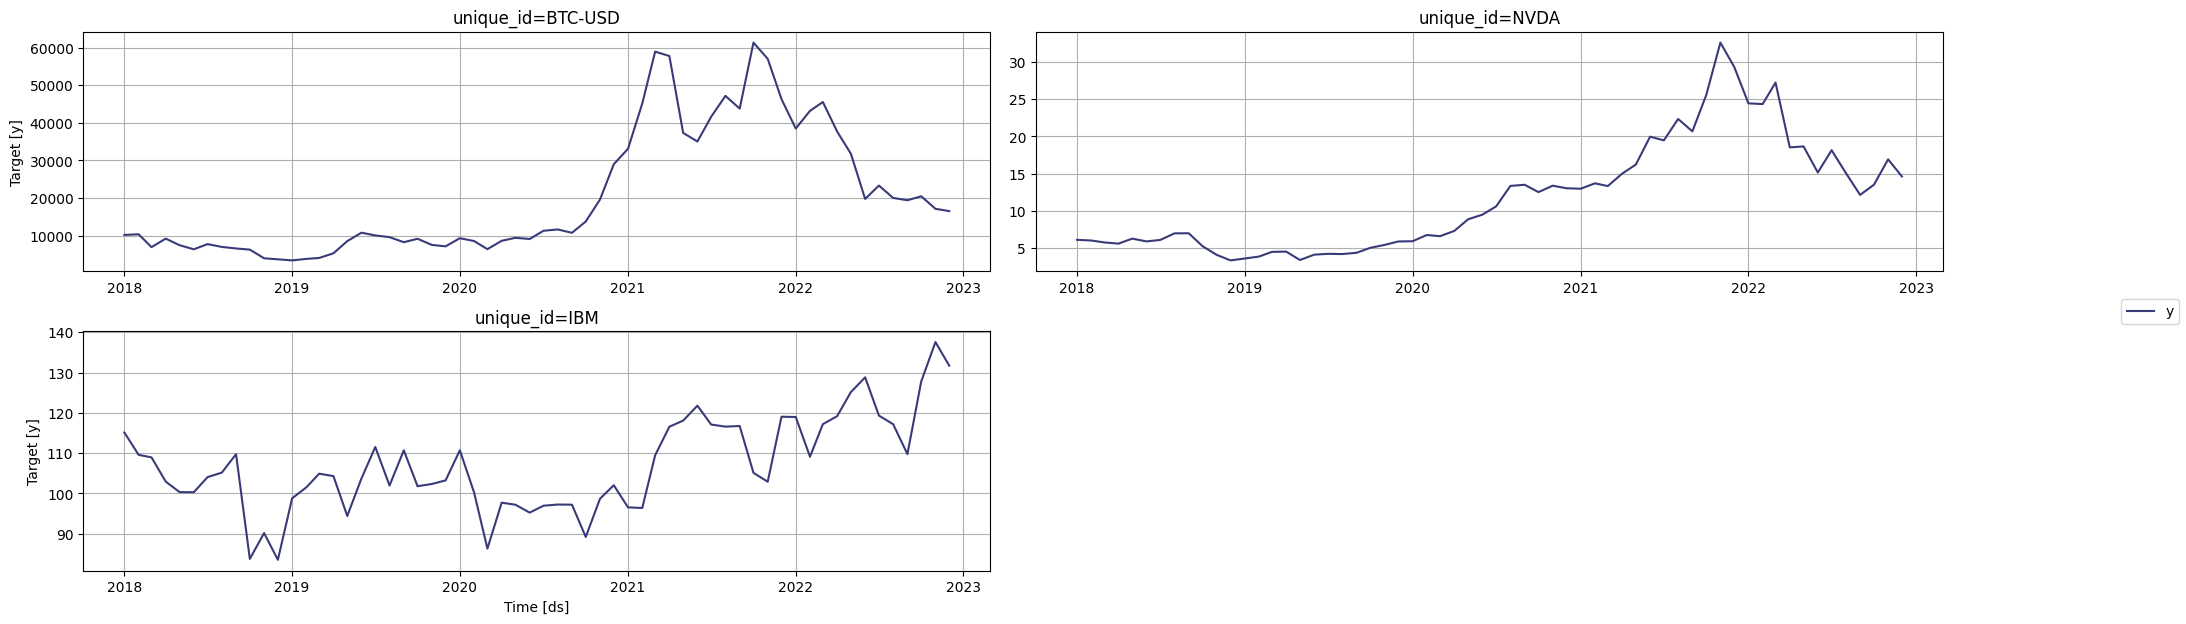

In [7]:
StatsForecast.plot(prices)

In [8]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns = returns.dropna(subset=['y'])
returns

,unique_id,ds,y
1,BTC-USD,2018-02-01,0.017150
2,BTC-USD,2018-03-01,-0.399482
3,BTC-USD,2018-04-01,0.281480
4,BTC-USD,2018-05-01,-0.209476
5,BTC-USD,2018-06-01,-0.157203
...,...,...,...
175,IBM,2022-08-01,-0.018053
176,IBM,2022-09-01,-0.065494
177,IBM,2022-10-01,0.151827
178,IBM,2022-11-01,0.073922


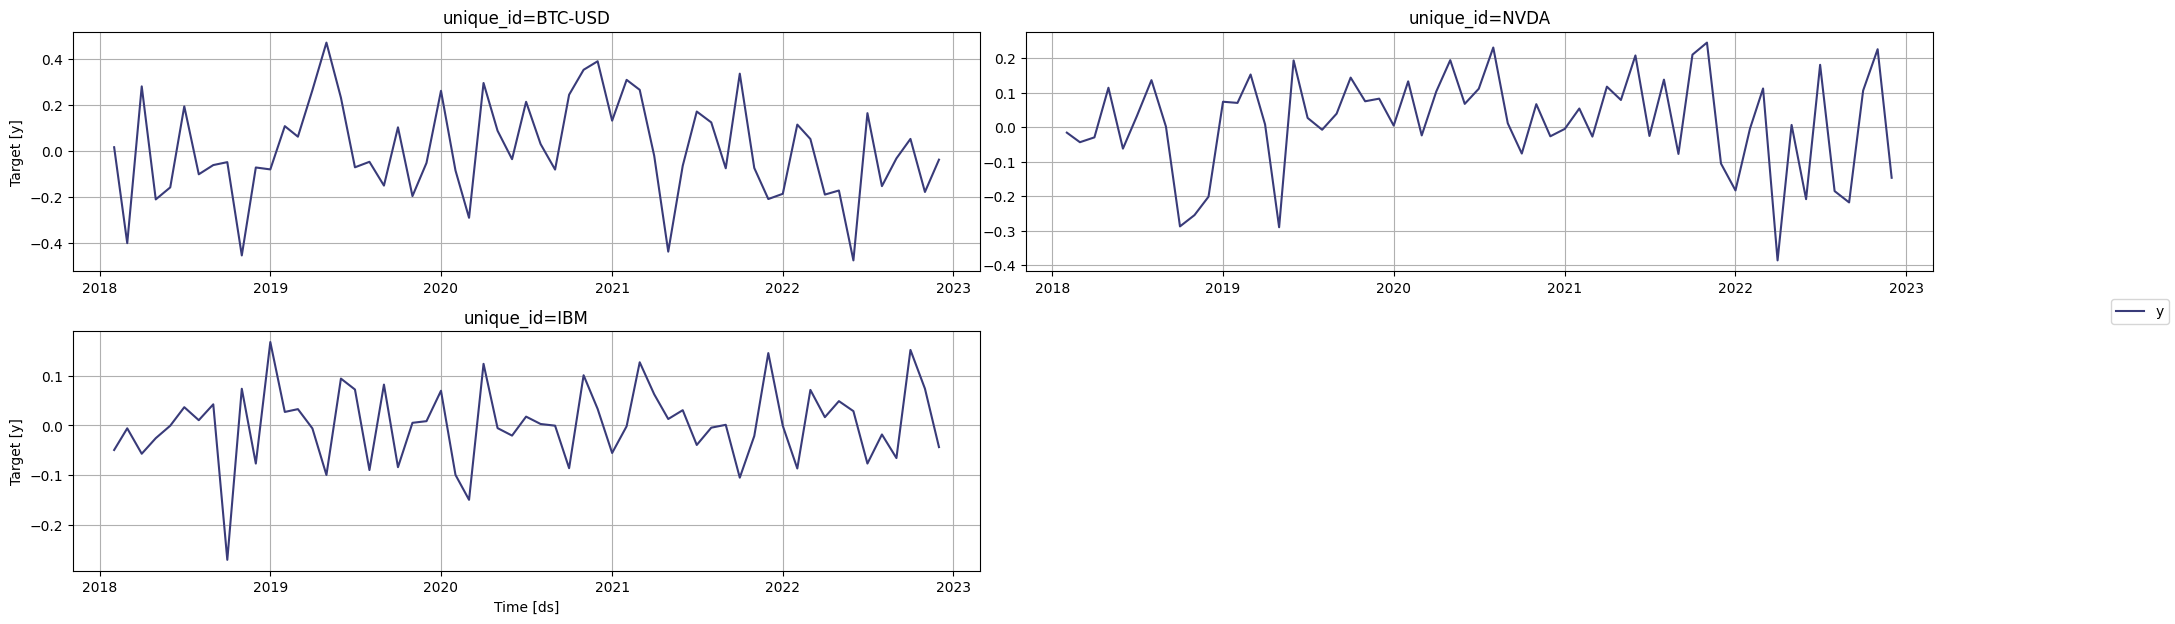

In [9]:
StatsForecast.plot(returns)

<Figure size 1500x2000 with 0 Axes>

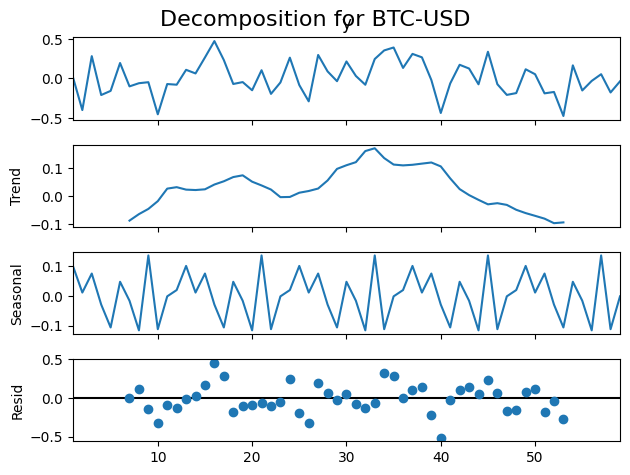

<Figure size 1500x2000 with 0 Axes>

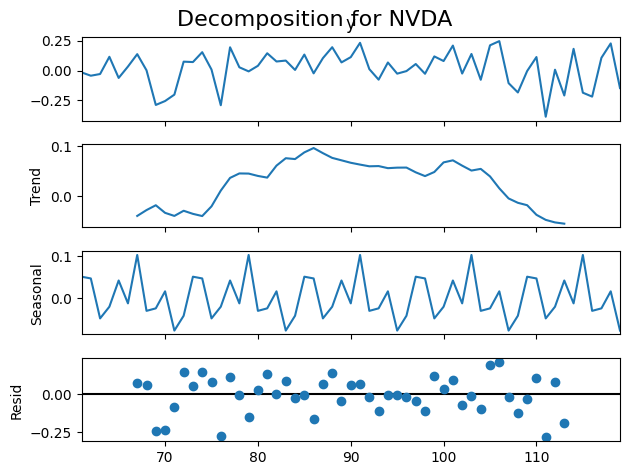

<Figure size 1500x2000 with 0 Axes>

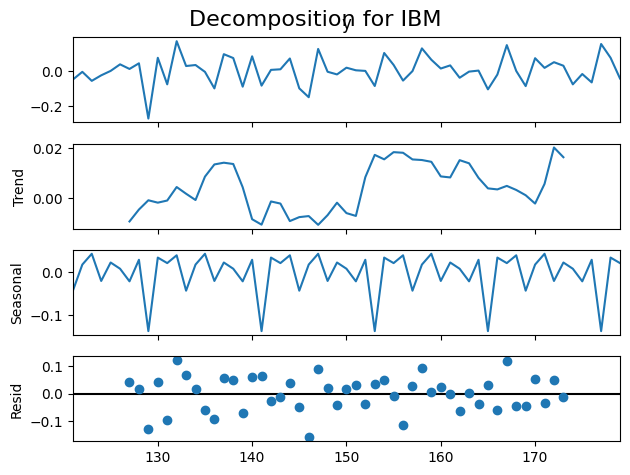

In [10]:
# Descomposición estacional
unique_ids = returns['unique_id'].unique()

for unique_id in unique_ids:
    series = returns[returns['unique_id'] == unique_id]
    
    # Asegurarse de que hay suficientes datos para la descomposición
    if len(series) >= 24:  # Al menos dos años de datos mensuales
        decomposition = seasonal_decompose(series['y'], model='additive', period=12)
        
        # Graficar
        plt.figure(figsize=(15, 20))
        decomposition.plot()
        plt.suptitle(f'Decomposition for {unique_id}', fontsize=16)
        plt.show()
    else:
        print(f"Not enough data to decompose for {unique_id}")

In [11]:
models = [Naive(), AutoCES(), AutoETS(), AutoTheta(), AutoARIMA()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)
sf.fit()

StatsForecast(models=[Naive,CES,AutoETS,AutoTheta,AutoARIMA])

Modelo: Naive
No residuals found for Naive
Modelo: AutoCES


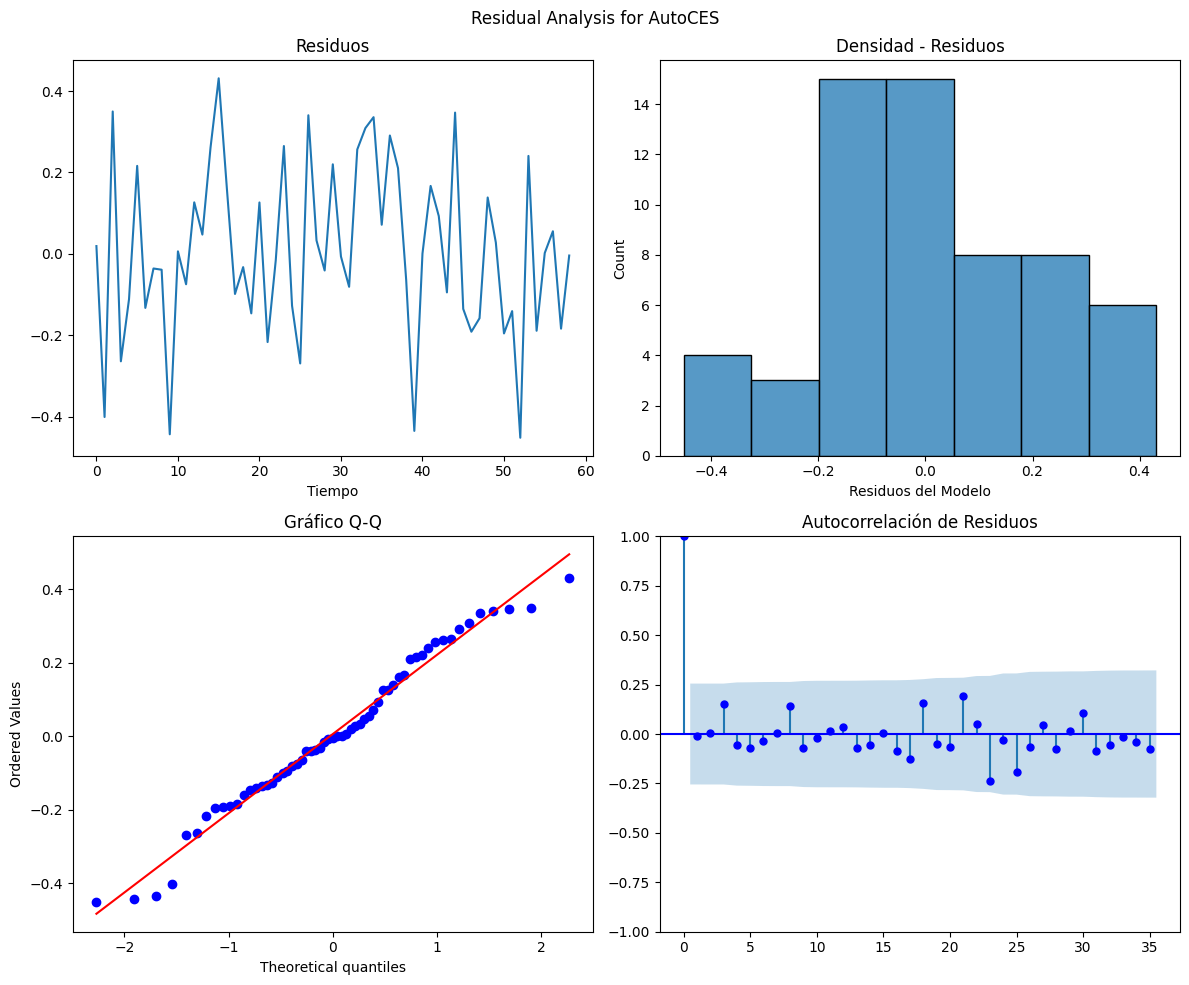

Modelo: AutoETS


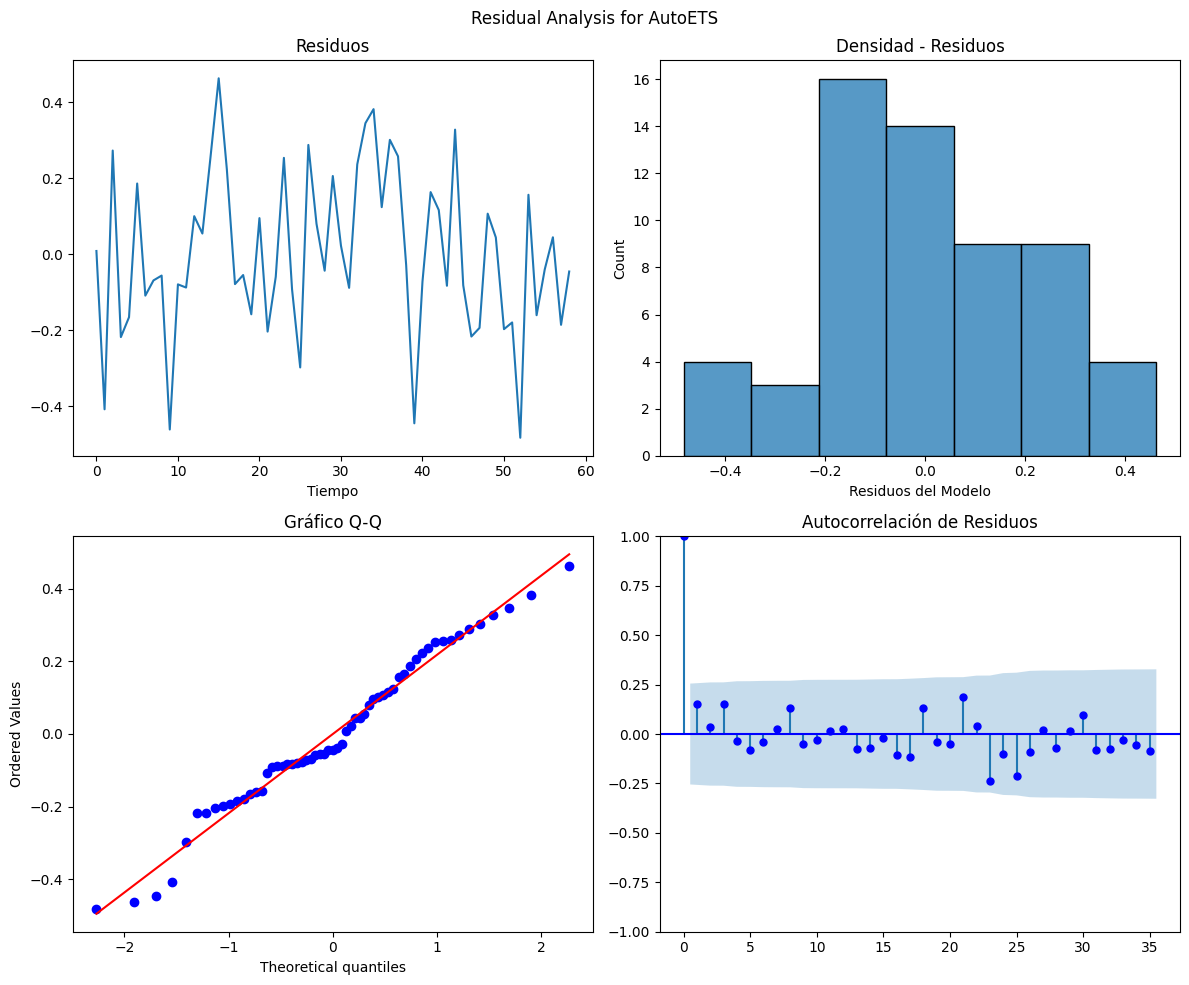

Modelo: AutoTheta


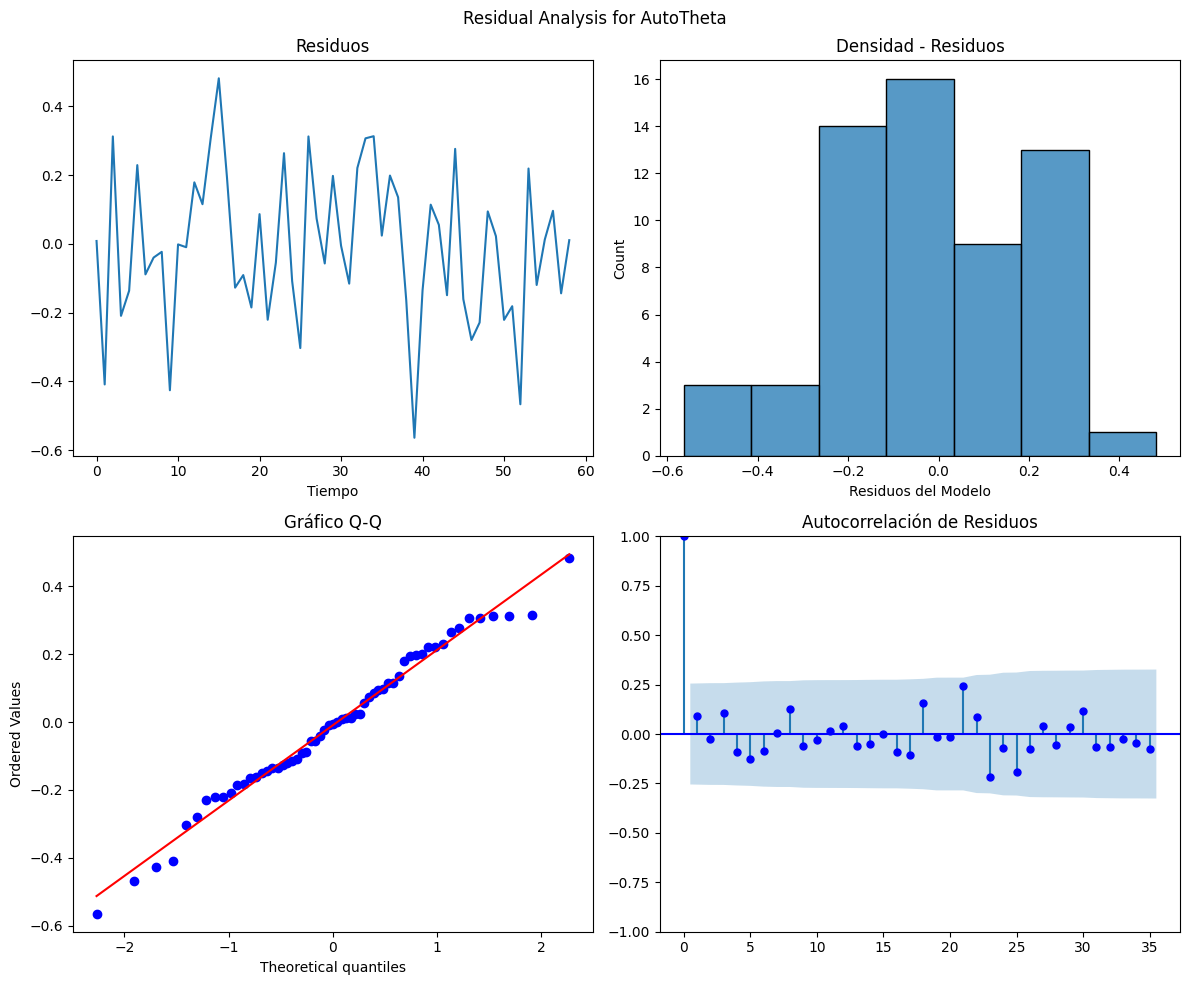

Modelo: AutoARIMA
(0, 0, 0, 0, 1, 0, 0)


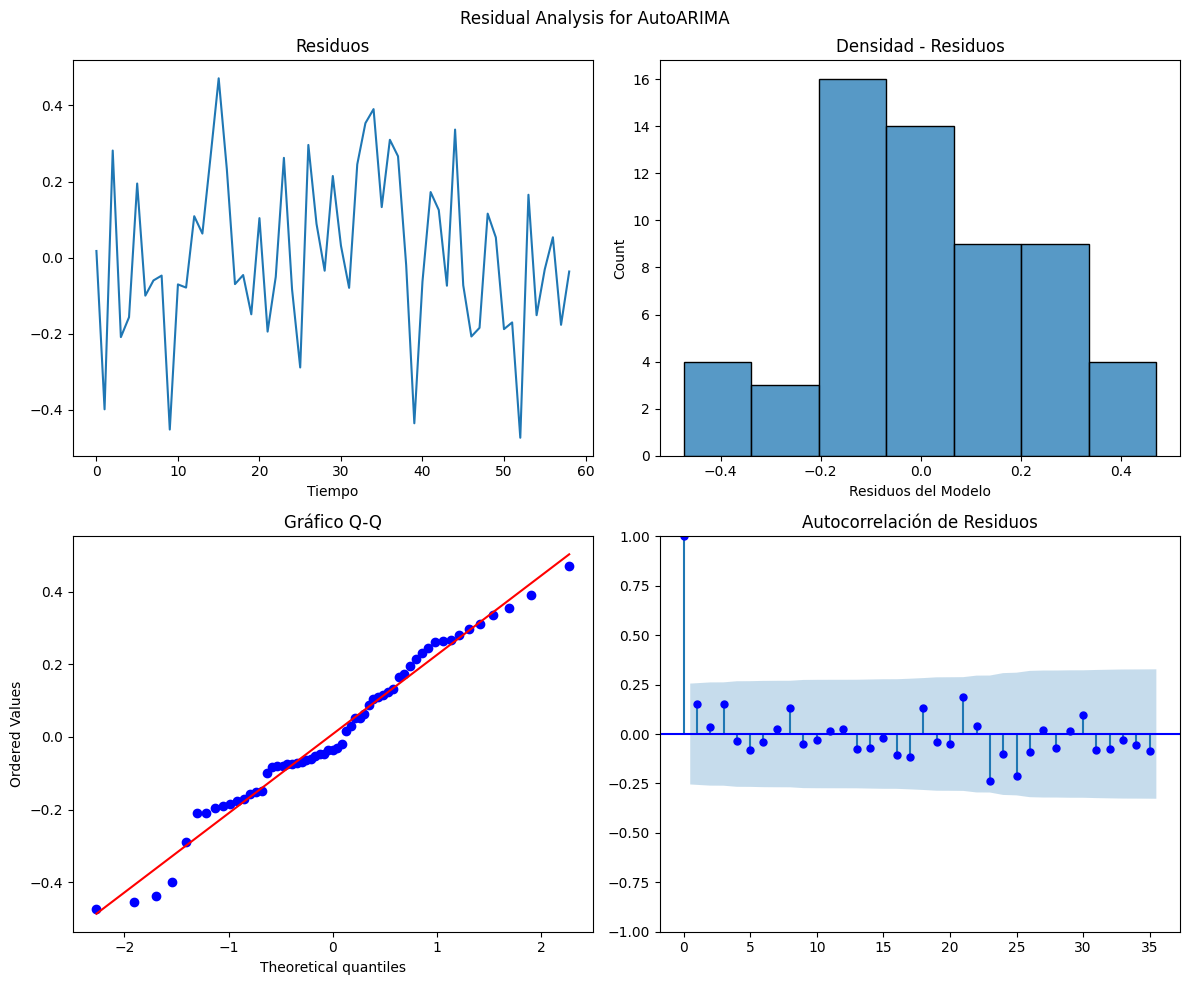

In [12]:
# Convertir sf.fitted_ a un diccionario
fitted_dict = {model_name: model_result for model_name, model_result in zip(models, sf.fitted_[0])}

# Iterar sobre los modelos ajustados y visualizar los residuos
for model in models:
    model_name = type(model).__name__
    model_result = fitted_dict[model]
    
    print(f"Modelo: {model_name}")

    # Verificar si el modelo tiene residuals
    if 'residuals' in model_result.model_:
        # Imprimir los componentes del modelo si están disponibles
        if 'arma' in model_result.model_:
            print(model_result.model_['arma'])

        # Residuales del modelo
        residual = pd.DataFrame(model_result.model_.get("residuals"), columns=["Residuos del Modelo"])

        # Visualización de los residuos
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        # Residuales a lo largo del tiempo
        residual['Residuos del Modelo'].plot(ax=axs[0, 0])
        axs[0, 0].set_title("Residuos")
        axs[0, 0].set_xlabel('Tiempo')

        # Histograma de los residuos
        sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
        axs[0, 1].set_title("Densidad - Residuos")

        # Gráfico Q-Q
        stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
        axs[1, 0].set_title('Gráfico Q-Q')

        # ACF de los residuos
        plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
        axs[1, 1].set_title("Autocorrelación de Residuos")

        plt.suptitle(f'Residual Analysis for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No residuals found for {model_name}")

In [13]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [14]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,Naive,CES,AutoETS,AutoTheta,AutoARIMA
0,BTC-USD,2022-01-01,2021-12-01,-0.185061,-0.207865,-0.028247,0.031990,0.072183,0.0
1,BTC-USD,2022-02-01,2021-12-01,0.115464,-0.207865,0.006179,0.031990,0.075082,0.0
2,BTC-USD,2022-03-01,2021-12-01,0.052878,-0.207865,0.004978,0.031990,0.077982,0.0
3,BTC-USD,2022-04-01,2022-03-01,-0.188507,0.052878,0.007299,0.029796,0.053349,0.0
4,BTC-USD,2022-05-01,2022-03-01,-0.170830,0.052878,0.003212,0.029796,0.055456,0.0


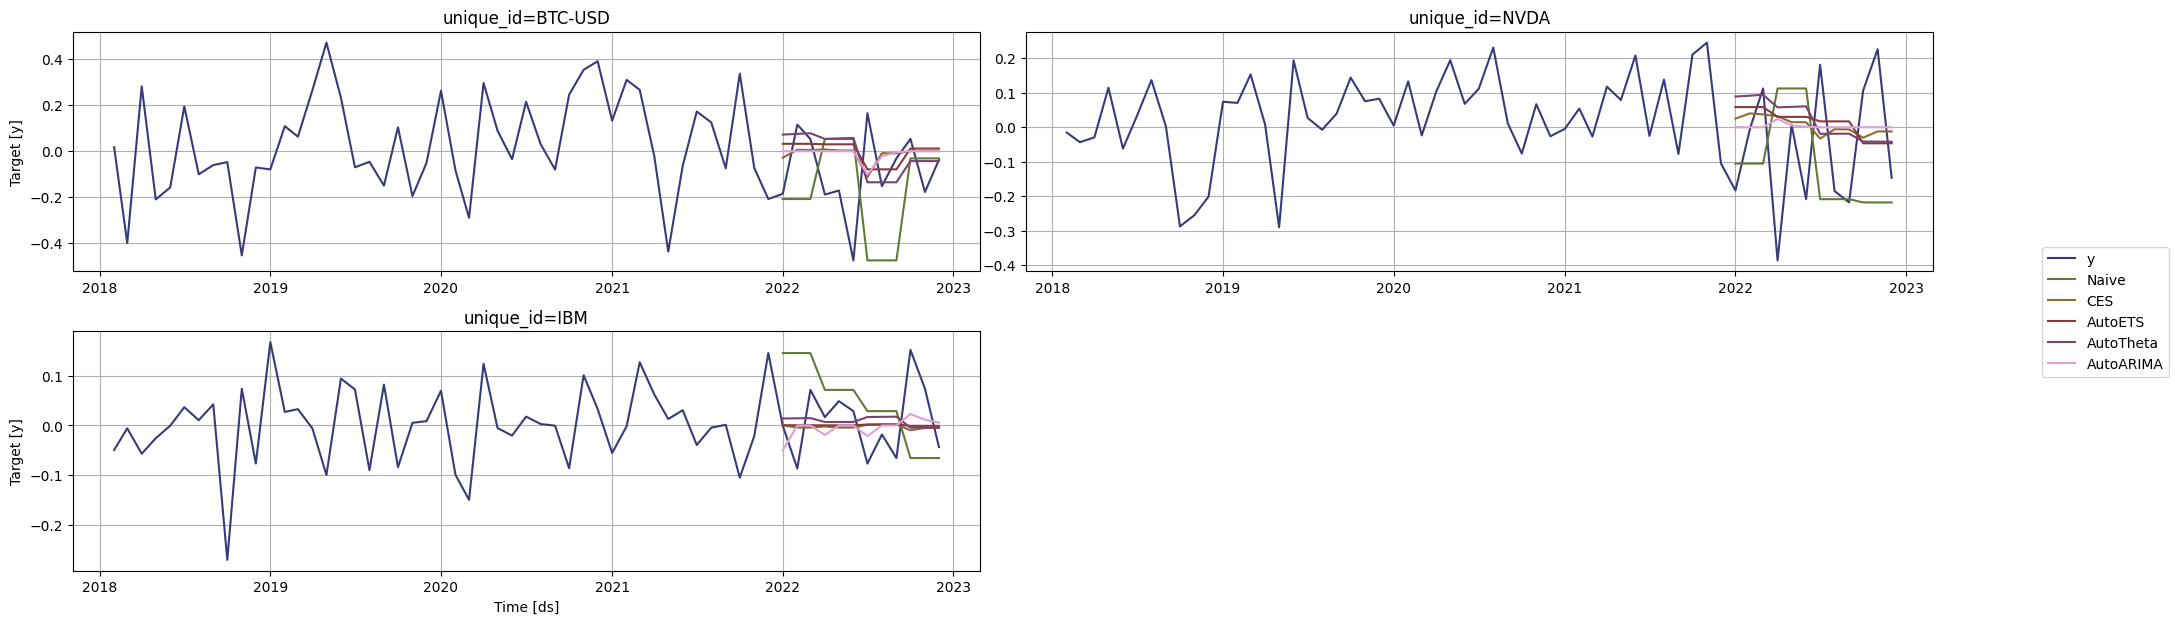

In [15]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [16]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae*100

,Naive,CES,AutoETS,AutoTheta,AutoARIMA
unique_id,,,,,
BTC-USD,27.000757,15.597966,15.730744,16.501104,15.647432
IBM,9.979359,5.901824,5.741848,6.094588,5.830654
NVDA,21.528868,17.421997,18.020813,18.639156,16.531233
